#### *This Notebook contains the Transfer Learning and Ensemble Learning based methodology for predicting the species of Snake from given image. Here the transfer learning models i.e. Xception, EfficientNetB0, DenseNet121 shows accuarcies of 75.86%, 81.22%, 77.01% respectively. The Ensemble Learning model gives an accuracy of 82%.*

### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception,EfficientNetB0,DenseNet121


### LOAD THE DATA

In [2]:
train_df = pd.read_csv("/kaggle/input/snakeclef2022/SnakeCLEF2022-TrainMetadata.csv")

### DATA PREPARATION

In [3]:
train_data = train_df[(train_df["code"]=="IN") | (train_df["code"]=="BD") | (train_df["code"]=="BT") |
                      (train_df["code"]=="MV") | (train_df["code"]=="NP") | (train_df["code"]=="PK") |
                      (train_df["code"]=="LK")]

train_data['file_path']="/kaggle/input/snakeclef2022/SnakeCLEF2022-medium_size/SnakeCLEF2022-medium_size/"+train_data['file_path']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### WE HAVE SELECTED THE IMAGES FROM THE SNAKECLEF2022 DATASET BASED ON THEIR LOCATION. WE ARE CONSIDERING ONLY THE INDIAN SUBCONTINENT THAT INCLUDES INDIA,BANGLADESH,BHUTAN,MALDIVES,NEPAL,PAKISTAN AND SRILANKA.

In [4]:
snake_df = train_data[(train_data["binomial_name"]=="Naja naja") | (train_data["binomial_name"]=="Bungarus caeruleus") |
                      (train_data["binomial_name"]=="Daboia russelii") | (train_data["binomial_name"]=="Echis carinatus") ]

#### IN THE PROPOESD METHODOLOGY, WE ARE ONLY CONCERN ABOUT THE FOUR SNAKE SPECIES i.e. NAJA NAJA, BUNGARUS CAERULES, DABOIA RUSSELII, ECHIS CARINATUS.

In [111]:
snake_df.head()

,observation_id,endemic,binomial_name,country,code,class_id,file_path
1294,54747641,False,Daboia russelii,Maharashtra,IN,415,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
1326,77219002,False,Echis carinatus,Gujarat,IN,521,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
1327,77219002,False,Echis carinatus,Gujarat,IN,521,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
1328,77219002,False,Echis carinatus,Gujarat,IN,521,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
1391,54717670,False,Daboia russelii,Maharashtra,IN,415,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...


In [8]:
snake_df.shape

(1305, 7)

In [9]:
snake_df['binomial_name'].value_counts()

Naja naja             577
Daboia russelii       342
Echis carinatus       205
Bungarus caeruleus    181
Name: binomial_name, dtype: int64

#### THERE ARE 1305 IMAGES OF SNAKES BELONGING TO FOUR CLASSES.

### SAMPLE IMAGE

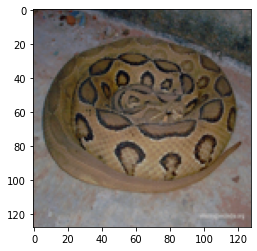

In [10]:
image = Image.open(snake_df.iloc[10]["file_path"])
image = image.resize((128,128))
plt.imshow(image)

In [11]:
print(snake_df.iloc[10]["binomial_name"])
print(snake_df.iloc[10]["class_id"])

Daboia russelii
415


#### THE ABOVE SNAKE BELONGS TO DABOIA RUSSELII SPECIES.

### SELECTING FEATURE AND TARGET

In [12]:
X =[]
Y = []
for i in range (len(snake_df)):
    image = Image.open(snake_df.iloc[i]["file_path"]).convert("RGB")
    image = image.resize((128,128))
    image = np.array(image,dtype="uint8")
    X.append(image)
    Y.append(snake_df.iloc[i]["class_id"])

In [13]:
np.unique(Y)

array([220, 415, 521, 985])

In [14]:
x_labels = np.array(X)
x_labels.shape

(1305, 128, 128, 3)

In [15]:
labels_array = []
for i in Y:
    a=[]
    a.append(i)
    labels_array.append(a)
y_label = np.array(labels_array)
y_label.shape

(1305, 1)

In [107]:
print(y_label)

[[415]
 [521]
 [521]
 ...
 [415]
 [415]
 [415]]


#### ENCODING THE TARGET CLASSES

In [17]:
encoder = LabelEncoder()
y_label_new = encoder.fit_transform(y_label)
y_label_new = y_label_new.reshape(1305,1)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### SPLITTING THE DATA INTO TRAINING AND TESTING SETS

In [19]:
X_train,X_test,y_train,y_test = train_test_split(x_labels,y_label_new,test_size=0.20,random_state=1)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1044, 128, 128, 3)
(1044, 1)
(261, 128, 128, 3)
(261, 1)


### BUILDING TRANSFER LEARNING MODEL

In [22]:
num_classes = 4
batch_size=16
epochs=50

In [35]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.001))(global_average_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def fit_model(model):
    history = model.fit(X_train, y_train,batch_size=batch_size,
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=len(X_test) // batch_size,
                        callbacks=[learning_rate_reduction])
    return history

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=5,monitor='val_accuracy')

### XCEPTION MODEL

In [25]:
base_model = Xception(input_shape=(128,128, 3), include_top=False, weights="imagenet")
model = create_model(base_model)

2023-02-03 18:34:48.017856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 18:34:48.221009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 18:34:48.222021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 18:34:48.223441: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 3s 0us/step


In [26]:
history = fit_model(model)

2023-02-03 18:35:09.410013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-02-03 18:35:14.079168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 16s 92ms/step - loss: 1.2243 - accuracy: 0.5058 - val_loss: 11.3714 - val_accuracy: 0.4688
Epoch 2/50
65/65 [==============================] - 5s 80ms/step - loss: 1.0295 - accuracy: 0.5768 - val_loss: 12.3508 - val_accuracy: 0.5156
Epoch 3/50
65/65 [==============================] - 5s 78ms/step - loss: 0.8091 - accuracy: 0.6907 - val_loss: 3.7267 - val_accuracy: 0.4297
Epoch 4/50
65/65 [==============================] - 5s 78ms/step - loss: 0.6363 - accuracy: 0.7733 - val_loss: 3.0895 - val_accuracy: 0.5977
Epoch 5/50
65/65 [==============================] - 5s 78ms/step - loss: 0.5549 - accuracy: 0.8016 - val_loss: 1.7124 - val_accuracy: 0.5312
Epoch 6/50
65/65 [==============================] - 5s 77ms/step - loss: 0.3904 - accuracy: 0.8833 - val_loss: 1.7220 - val_accuracy: 0.6016
Epoch 7/50
65/65 [==============================] - 5s 78ms/step - loss: 0.3444 - accuracy: 0.8755 - val_loss: 1.0841 - val_accuracy: 0.6680
Epoch 8/50
65/65 [===

In [42]:
model.save('models/model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


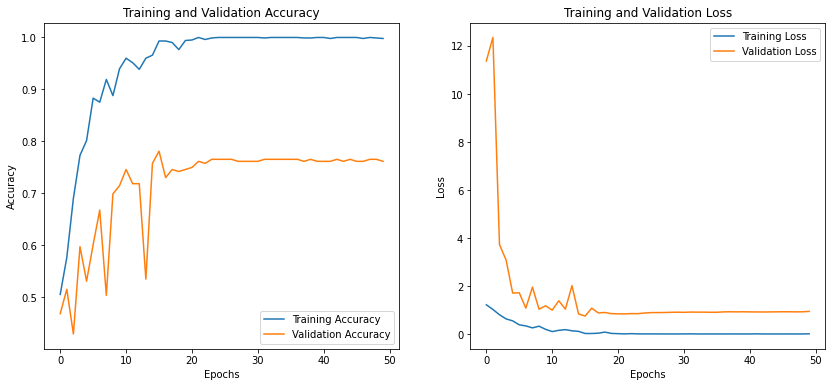

In [36]:
plot_history(history)

In [28]:
evaluate = model.evaluate(X_test,y_test)
print(evaluate[1])

9/9 [==============================] - 0s 37ms/step - loss: 0.9681 - accuracy: 0.7586
0.7586206793785095


### EFFICIENTNET B0 MODEL

In [29]:
base_model_2 = EfficientNetB0(input_shape=(128,128, 3), include_top=False, weights="imagenet")
model_2 = create_model(base_model_2)

16719872/16705208 [==============================] - 1s 0us/step


In [32]:
history_2 = fit_model(model_2)

Epoch 1/50
65/65 [==============================] - 13s 88ms/step - loss: 1.0747 - accuracy: 0.5731 - val_loss: 0.9226 - val_accuracy: 0.6758
Epoch 2/50
65/65 [==============================] - 4s 62ms/step - loss: 0.5941 - accuracy: 0.7821 - val_loss: 0.7537 - val_accuracy: 0.7461
Epoch 3/50
65/65 [==============================] - 4s 61ms/step - loss: 0.3665 - accuracy: 0.8774 - val_loss: 0.9115 - val_accuracy: 0.7344
Epoch 4/50
65/65 [==============================] - 4s 65ms/step - loss: 0.2825 - accuracy: 0.8988 - val_loss: 1.1242 - val_accuracy: 0.7500
Epoch 5/50
65/65 [==============================] - 4s 61ms/step - loss: 0.2999 - accuracy: 0.8930 - val_loss: 1.3243 - val_accuracy: 0.6953
Epoch 6/50
65/65 [==============================] - 4s 63ms/step - loss: 0.2544 - accuracy: 0.9144 - val_loss: 1.1856 - val_accuracy: 0.7188
Epoch 7/50
65/65 [==============================] - 4s 62ms/step - loss: 0.1949 - accuracy: 0.9455 - val_loss: 1.0749 - val_accuracy: 0.7422
Epoch 8/50
6

In [43]:
model_2.save('models/model_2.h5')

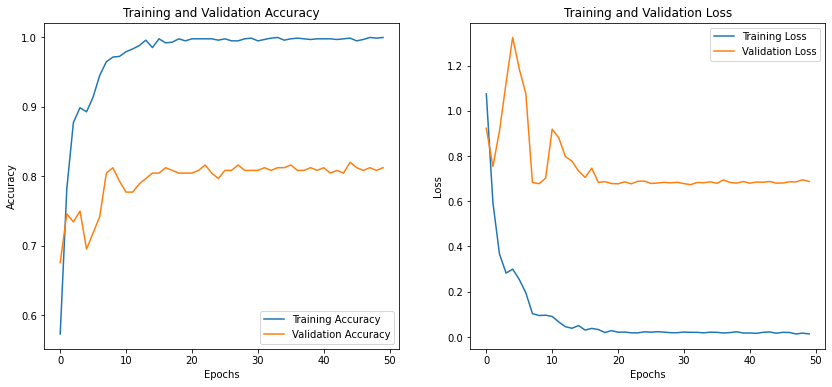

In [37]:
plot_history(history_2)

In [34]:
evaluate_2 = model_2.evaluate(X_test,y_test)
print(evaluate_2[1])

9/9 [==============================] - 0s 32ms/step - loss: 0.7074 - accuracy: 0.8123
0.8122605085372925


### DENSENET 121 MODEL

In [38]:
base_model_3 = DenseNet121(input_shape=(128,128, 3), include_top=False, weights="imagenet")
model_3 = create_model(base_model_3)

29097984/29084464 [==============================] - 2s 0us/step


In [39]:
history_3 = fit_model(model_3)

Epoch 1/50
65/65 [==============================] - 16s 95ms/step - loss: 1.4811 - accuracy: 0.4558 - val_loss: 17.5233 - val_accuracy: 0.1328
Epoch 2/50
65/65 [==============================] - 5s 69ms/step - loss: 1.1100 - accuracy: 0.5233 - val_loss: 2.1491 - val_accuracy: 0.5117
Epoch 3/50
65/65 [==============================] - 4s 65ms/step - loss: 0.9068 - accuracy: 0.6323 - val_loss: 1.4306 - val_accuracy: 0.5820
Epoch 4/50
65/65 [==============================] - 4s 66ms/step - loss: 0.9394 - accuracy: 0.6148 - val_loss: 47.7342 - val_accuracy: 0.4258
Epoch 5/50
65/65 [==============================] - 4s 69ms/step - loss: 0.8654 - accuracy: 0.6702 - val_loss: 5.9003 - val_accuracy: 0.3203
Epoch 6/50
65/65 [==============================] - 5s 71ms/step - loss: 0.7627 - accuracy: 0.7091 - val_loss: 1.6035 - val_accuracy: 0.6094
Epoch 7/50
65/65 [==============================] - 4s 69ms/step - loss: 0.5413 - accuracy: 0.8064 - val_loss: 1.1644 - val_accuracy: 0.6484
Epoch 8/50

In [44]:
model_3.save('models/model_3.h5')

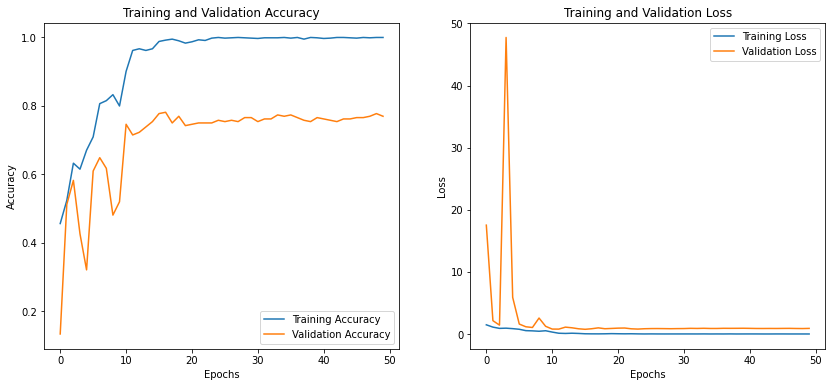

In [40]:
plot_history(history_3)

In [41]:
evaluate_3 = model_3.evaluate(X_test,y_test)
print(evaluate_3[1])

9/9 [==============================] - 1s 59ms/step - loss: 0.9124 - accuracy: 0.7701
0.7701149582862854


### ENSEMBLE MODEL

In [79]:
def load_all_models():
    all_models = []
    model_names = ['model.h5', 'model_2.h5', 'model_3.h5']
    for model_name in model_names:
        filename = os.path.join('models', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

def ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(merge)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [80]:
models = load_all_models()
model_e = ensemble_model(models)

loaded: models/model.h5
loaded: models/model_2.h5
loaded: models/model_3.h5


In [81]:
X = [X_train for _ in range(len(model_e.input))]
X_t = [X_test for _ in range(len(model_e.input))]

In [82]:
history_e = model_e.fit(X, y_train,
                    batch_size=batch_size,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_t, y_test),
                    validation_steps=len(X_test) // batch_size)

Epoch 1/50
65/65 [==============================] - 20s 126ms/step - loss: 0.9507 - accuracy: 0.7750 - val_loss: 1.0664 - val_accuracy: 0.6680
Epoch 2/50
65/65 [==============================] - 4s 57ms/step - loss: 0.7519 - accuracy: 0.8346 - val_loss: 0.9494 - val_accuracy: 0.6836
Epoch 3/50
65/65 [==============================] - 4s 62ms/step - loss: 0.5990 - accuracy: 0.9232 - val_loss: 0.8623 - val_accuracy: 0.7539
Epoch 4/50
65/65 [==============================] - 4s 60ms/step - loss: 0.4931 - accuracy: 0.9942 - val_loss: 0.7985 - val_accuracy: 0.7852
Epoch 5/50
65/65 [==============================] - 4s 66ms/step - loss: 0.3960 - accuracy: 0.9990 - val_loss: 0.7517 - val_accuracy: 0.7891
Epoch 6/50
65/65 [==============================] - 4s 66ms/step - loss: 0.3373 - accuracy: 0.9990 - val_loss: 0.7167 - val_accuracy: 0.8008
Epoch 7/50
65/65 [==============================] - 4s 58ms/step - loss: 0.2804 - accuracy: 0.9990 - val_loss: 0.6906 - val_accuracy: 0.8047
Epoch 8/50


In [83]:
model_e.save('models/model_e.h5')

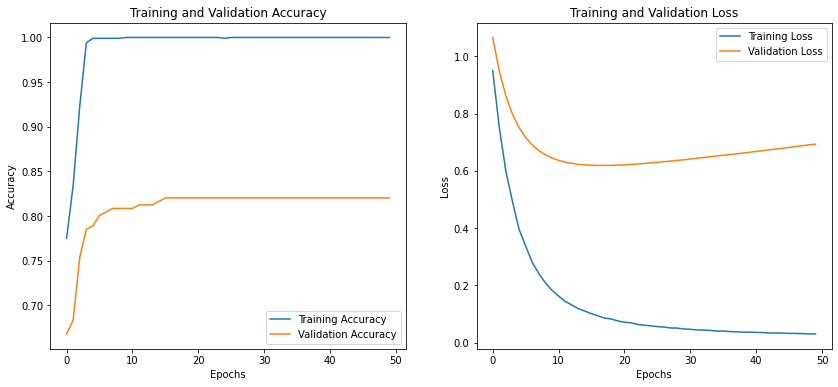

In [84]:
plot_history(history_e)

In [85]:
evaluate_e = model_e.evaluate(X_t,y_test)
print(evaluate_e[1])

9/9 [==============================] - 1s 67ms/step - loss: 0.6949 - accuracy: 0.8199
0.8199234008789062


### PREDICTION

In [112]:
# 0 - 415 - Daboia russelii
# 1 - 521 - Echis carinatus
# 2 - 985 - Naja Naja
# 3 - 220 - Bungarus caeruieus

In [88]:
predict = model_e.predict(X_t)

In [99]:
np.argmax(predict[0])

3

In [113]:
prediction = []
original = y_test
image = []
count = 0

for i in range(0, len(X_t[0])):
    pred = np.argmax(predict[i])
    prediction.append(pred)

(-0.5, 127.5, 127.5, -0.5)

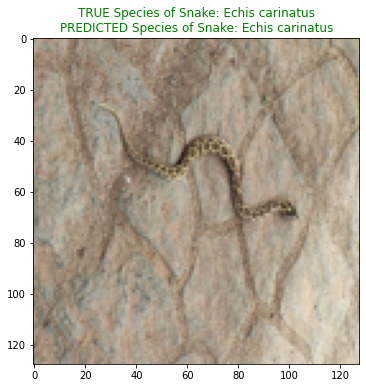

In [130]:
classes = ["Daboia russelii","Echis carinatus","Naja Naja","Bungarus caeruieus"]

import random
plt.figure(figsize=(6,6))
random_int_index = random.choice(range(len(X_test)))
plt.imshow(X_test[random_int_index])
if prediction[random_int_index] == original[random_int_index]:
    color = "g"
else:
    color = "r"
plt.title("TRUE Species of Snake: " + classes[original[random_int_index][0]] + "\n" + "PREDICTED Species of Snake: " +
              classes[prediction[random_int_index]], color = color)
plt.axis(True)